In [ ]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import numpy as np
from numpy.ma.core import sqrt
import random
import json

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR

import time

import cv2

import glob
from tqdm import tqdm

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
!pip install einops
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Data

In [ ]:
train_path = r'/content/drive/MyDrive/ImageNet100/train.X'
test_path = r'/content/drive/MyDrive/ImageNet100/val.X'
labels_path = r'/content/drive/MyDrive/ImageNet100/Labels.json'

f = open(labels_path)
data = json.load(f)

labels = list(data.keys())

In [ ]:
class ImageNet100(Dataset):
  def __init__(self, file_path, labels, transform=False):
    self.file_path = file_path
    self.labels = labels
    self.transform = transform

    self.image_paths = []

    for data_path in glob.glob(self.file_path + '/*'):
      self.image_paths.append(glob.glob(data_path + '/*'))

    self.image_paths = list(flatten(self.image_paths))
    random.shuffle(self.image_paths)

  def __getitem__(self, idx):
    label = str(self.image_paths[idx])
    image = cv2.imread(label)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    label = label.split('/')[-2]
    label = self.labels.index(label)

    if self.transform:
      image = self.transform(image)

    return image, torch.tensor(label)

  def __len__(self):
    return len(self.image_paths)

In [ ]:
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop(224),
    normalize
])

In [ ]:
train_dataset = ImageNet100(train_path, labels, transform)
test_dataset = ImageNet100(test_path, labels, transform)

In [ ]:
train_img, train_label = train_dataset[1000]
train_img.shape, train_label

(torch.Size([3, 224, 224]), tensor(63))

Text(0.5, 1.0, 'tensor(63)')

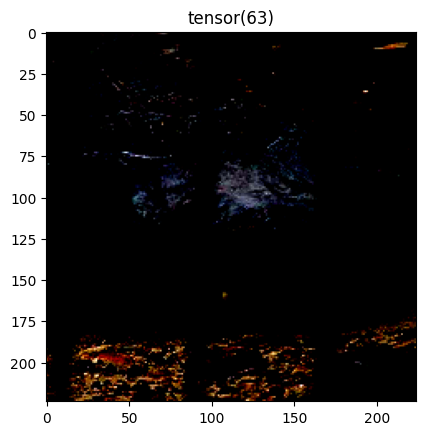

In [ ]:
train_img = train_img.permute(1, 2, 0).numpy()

plt.imshow(train_img)
plt.title(train_label)

In [ ]:
len(train_dataset)

130000

In [ ]:
test_img, test_label = test_dataset[1000]
test_img.shape, test_label

(torch.Size([3, 224, 224]), tensor(53))

Text(0.5, 1.0, 'tensor(53)')

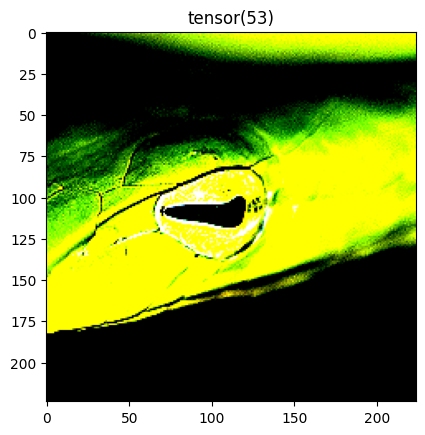

In [ ]:
test_img = test_img.permute(1, 2, 0).numpy()

plt.imshow(test_img)
plt.title(test_label)

In [ ]:
len(test_dataset)

5000

### Models

In [ ]:
class PatchEmbedding(nn.Module):
  def __init__(self, img_size: int=224, in_channels: int=3, patch_size: int=16, embedding_size: int=512):
    super(PatchEmbedding, self).__init__()

    self.projection = nn.Sequential(
        Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
        nn.Linear(patch_size * patch_size * in_channels, embedding_size)
    )

    self.cls_token = nn.Parameter(torch.rand(1, 1, embedding_size))

    num_patches = int(img_size // patch_size)**2
    self.pos_emb = nn.Parameter(torch.rand(num_patches + 1, embedding_size))

  def forward(self, imgs):
    b, _, _, _ = imgs.size()
    output = self.projection(imgs)
    cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
    output = torch.cat((output, cls_tokens), dim=1)
    output += self.pos_emb

    return output

In [ ]:
class MultiHeadSelfAttention(nn.Module):
  def __init__(self, emb_size: int=512, n_heads: int=8, dropout: float=0):
    super(MultiHeadSelfAttention, self).__init__()

    assert emb_size % n_heads == 0, f'Embedding size = {emb_size} and Number of heads = {n_heads} are not divisible!'

    self.emb_size = emb_size
    self.n_heads = n_heads
    self.scale = sqrt(emb_size // n_heads)

    self.queries = nn.Linear(emb_size, emb_size)
    self.keys = nn.Linear(emb_size, emb_size)
    self.values = nn.Linear(emb_size, emb_size)

    self.projection = nn.Linear(emb_size, emb_size)


  def forward(self, x):
    N, num_patches, _, = x.size()
    Q = self.queries(x)
    K = self.keys(x)
    V = self.values(x)

    Q = Q.view(N, self.n_heads, num_patches, self.emb_size // self.n_heads)
    K = K.view(N, self.n_heads, num_patches, self.emb_size // self.n_heads)
    V = V.view(N, self.n_heads, num_patches, self.emb_size // self.n_heads)

    energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) // self.scale

    attention = F.softmax(energy, dim=-1)
    out = torch.matmul(attention, V)
    out = out.view(N, num_patches, self.emb_size)
    out = self.projection(out)

    return out, attention

In [ ]:
class TransformerEncoder(nn.Module):
  def __init__(self, emb_size: int=512, n_heads: int=8, mlp_size: int=3072):
    super(TransformerEncoder, self).__init__()

    self.layer_norm1 = nn.LayerNorm(emb_size)
    self.attention = MultiHeadSelfAttention(emb_size, n_heads)
    self.layer_norm2 = nn.LayerNorm(emb_size)

    self.mlp = nn.Sequential(
        nn.Linear(emb_size, mlp_size),
        nn.GELU(),
        nn.Linear(mlp_size, emb_size)
    )

  def forward(self, x):
    res1 = x
    x = self.layer_norm1(x)
    x, _ = self.attention(x)

    x += res1

    res2 = x
    x = self.layer_norm2(x)
    x = self.mlp(x)

    x += res2

    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, img_size: int=224,
                     in_channels: int=3,
                     patch_size: int=16,
                     emb_size: int=768,
                     n_encoders: int=12,
                     n_heads: int=16,
                     mlp_size: int=3072,
                     n_classes: int=1000):

    super(VisionTransformer, self).__init__()

    self.projection = PatchEmbedding(img_size, in_channels, patch_size, emb_size)

    encoders = []

    for i in range(n_encoders):
      encoder = TransformerEncoder(emb_size, n_heads, mlp_size)
      encoders.append(encoder)

    self.Encoder = nn.Sequential(*encoders)
    self.layer_norm = nn.LayerNorm(emb_size)

    self.mlp_head = nn.Linear(emb_size, n_classes)

  def forward(self, x):
    x = self.projection(x)
    x = self.Encoder(x)
    x = self.layer_norm(x)

    out = self.mlp_head(x[:, 0, :])

    return out

In [ ]:
from torchvision.models import vit_b_16
model = vit_b_16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 83.9MB/s]


In [ ]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [ ]:
vit = VisionTransformer()

In [ ]:
total_params_model = sum(p.numel() for p in vit.parameters())
print(f"Number of parameters: {total_params_model}")

Number of parameters: 86567656


In [ ]:
total_params_vit = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params_vit}")

Number of parameters: 86567656
